<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Excel

**xlwings Case Study**

Dr. Yves J. Hilpisch

In [1]:
import numpy as np
import pandas as pd
import xlwings as xw

## Modern Portfolio Theory

### Reading and Preparing the Data

In [2]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                 index_col=0, parse_dates=True).dropna()

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 12 columns):
AAPL.O    2138 non-null float64
MSFT.O    2138 non-null float64
INTC.O    2138 non-null float64
AMZN.O    2138 non-null float64
GS.N      2138 non-null float64
SPY       2138 non-null float64
.SPX      2138 non-null float64
.VIX      2138 non-null float64
EUR=      2138 non-null float64
XAU=      2138 non-null float64
GDX       2138 non-null float64
GLD       2138 non-null float64
dtypes: float64(12)
memory usage: 217.1 KB


In [4]:
rets = np.log(raw / raw.shift(1))

In [5]:
rets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 12 columns):
AAPL.O    2137 non-null float64
MSFT.O    2137 non-null float64
INTC.O    2137 non-null float64
AMZN.O    2137 non-null float64
GS.N      2137 non-null float64
SPY       2137 non-null float64
.SPX      2137 non-null float64
.VIX      2137 non-null float64
EUR=      2137 non-null float64
XAU=      2137 non-null float64
GDX       2137 non-null float64
GLD       2137 non-null float64
dtypes: float64(12)
memory usage: 217.1 KB


### Calculate Portfolio Statistics

In [6]:
symbols = ['AAPL.O', 'MSFT.O', 'INTC.O']

In [7]:
nos = len(symbols)

In [8]:
weights = nos * [1 / nos]
weights

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

In [9]:
def portfolio_return(weights, symbols):
    return np.dot(weights, rets[symbols].mean() * 252)

In [10]:
portfolio_return(weights, symbols)

0.15043164502022233

In [11]:
def portfolio_volatility(weights, symbols):
    return np.dot(weights, np.dot(rets[symbols].cov() * 252,
                                  weights)) ** 0.5

In [12]:
portfolio_volatility(weights, symbols)

0.18999165136812976

### Minimum Risk Portfolio

In [13]:
from scipy.optimize import minimize

In [14]:
bnds = [(0, 1) for _ in range(nos)]
bnds

[(0, 1), (0, 1), (0, 1)]

In [15]:
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

In [16]:
opt = minimize(portfolio_volatility, weights,
               bounds=bnds, constraints=cons,
               args=(symbols))

In [17]:
opt

     fun: 0.18975028137243513
     jac: array([0.18955235, 0.18987186, 0.18979875])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.31039995, 0.38320613, 0.30639392])

In [18]:
opt['x'].round(3)

array([0.31 , 0.383, 0.306])

In [49]:
def derive_min_risk_port(symbols):
    nos = len(symbols)
    bnds = [(0, 1) for _ in range(nos)]
    cons = {'type': 'eq',
            'fun': lambda weights: weights.sum() - 1}
    opt = minimize(portfolio_volatility, nos * [1 / nos],
               bounds=bnds, constraints=cons,
               args=(symbols))
    return opt['x']

In [50]:
derive_min_risk_port(symbols)

array([0.31039995, 0.38320613, 0.30639392])

### Monte Carlo Simulation

In [19]:
np.random.random()

0.5735259313463223

In [20]:
np.random.random((5, nos))

array([[0.27120932, 0.49823169, 0.97476899],
       [0.7379305 , 0.42972468, 0.66949055],
       [0.10675875, 0.61173042, 0.88389156],
       [0.15597706, 0.62347009, 0.24270599],
       [0.42968742, 0.63059616, 0.18975105]])

In [21]:
np.random.random((5, nos)).sum(axis=1)

array([2.16739307, 1.92549917, 1.17627835, 1.34042242, 1.21482676])

In [22]:
rpa = np.random.random((5, nos))

In [23]:
rpa.T / rpa.sum(axis=1)

array([[0.2256236 , 0.19107692, 0.2257354 , 0.09184873, 0.13520617],
       [0.14968511, 0.40516737, 0.41137328, 0.26404564, 0.54304314],
       [0.6246913 , 0.40375571, 0.36289132, 0.64410563, 0.32175069]])

In [24]:
(rpa.T / rpa.sum(axis=1)).T

array([[0.2256236 , 0.14968511, 0.6246913 ],
       [0.19107692, 0.40516737, 0.40375571],
       [0.2257354 , 0.41137328, 0.36289132],
       [0.09184873, 0.26404564, 0.64410563],
       [0.13520617, 0.54304314, 0.32175069]])

In [25]:
(rpa.T / rpa.sum(axis=1)).T.sum(axis=1)

array([1., 1., 1., 1., 1.])

In [26]:
rpa = np.random.random((250, nos))

In [27]:
rpa = (rpa.T / rpa.sum(axis=1)).T

In [28]:
rpa[:5]

array([[0.39151769, 0.17973507, 0.42874725],
       [0.25788839, 0.29400938, 0.44810223],
       [0.10907   , 0.49905231, 0.39187769],
       [0.22323016, 0.23893093, 0.53783891],
       [0.31557497, 0.02140036, 0.66302467]])

In [29]:
for w in rpa[:5]:
    print(w)

[0.39151769 0.17973507 0.42874725]
[0.25788839 0.29400938 0.44810223]
[0.10907    0.49905231 0.39187769]
[0.22323016 0.23893093 0.53783891]
[0.31557497 0.02140036 0.66302467]


In [30]:
pstats = [(portfolio_volatility(w, symbols),
           portfolio_return(w, symbols)) for w in rpa]

In [31]:
pstats = np.array(pstats)

In [32]:
pstats[:5]

array([[0.19377455, 0.15155832],
       [0.19188697, 0.1407761 ],
       [0.19596257, 0.13144087],
       [0.1953995 , 0.13506867],
       [0.2049348 , 0.13775868]])

In [33]:
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

In [34]:
' | '.join(symbols)

'AAPL.O | MSFT.O | INTC.O'

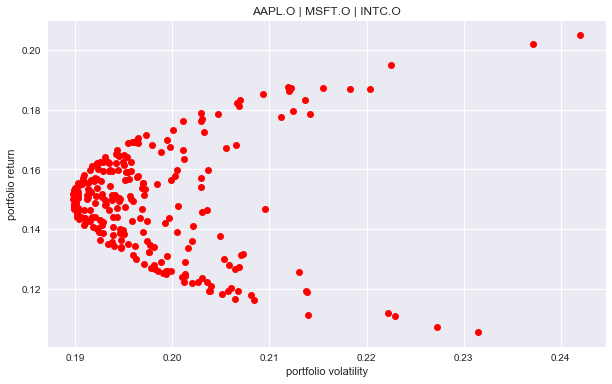

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(pstats[:, 0], pstats[:, 1], 'ro')
plt.xlabel('portfolio volatility')
plt.ylabel('portfolio return')
plt.title(' | '.join(symbols));

In [54]:
def simulate_port_stats(symbols, runs=250):
    rpa = np.random.random((runs, len(symbols)))
    rpa = (rpa.T / rpa.sum(axis=1)).T
    pstats = [(portfolio_volatility(w, symbols),
           portfolio_return(w, symbols)) for w in rpa]
    return np.array(pstats)

In [55]:
ps = simulate_port_stats(symbols)
ps[:7]

array([[0.18985689, 0.1517486 ],
       [0.19224161, 0.14554439],
       [0.20833661, 0.18146555],
       [0.19239707, 0.14292155],
       [0.20380485, 0.15739465],
       [0.19003082, 0.15278621],
       [0.19111303, 0.15873812]])

## Using Excel

In [36]:
wb = xw.Book()

In [37]:
sht = wb.sheets.active

In [38]:
sht

<Sheet [Book1]Sheet1>

In [39]:
sht.range('A1').value = 'Hi from xlwings.'

In [41]:
sht.range('B3').expand().value

[['symbols', 'weights'],
 ['AAPL.O', 0.25],
 ['MSFT.O', 0.25],
 ['AMZN.O', 0.25],
 ['GDX', 0.25]]

In [73]:
sht.range('B3').expand().options(pd.DataFrame,
                                 index=False).value

,symbols,weights
0,AAPL.O,0.25
1,SPY,0.25
2,GS.N,0.25
3,GDX,0.25


In [74]:
params = sht.range('B3').expand().options(pd.DataFrame,
                                 index=False).value

In [75]:
pr = portfolio_return(params['weights'], params['symbols'])
pr

0.06356135177382953

In [76]:
sht.range('B10').value = pr

In [77]:
pv = portfolio_volatility(params['weights'],
                          params['symbols'])
pv

0.17845172515074167

In [78]:
sht.range('C10').value = pv

In [79]:
mr = derive_min_risk_port(params['symbols'])
mr

array([1.42858152e-02, 9.11813813e-01, 9.54097912e-18, 7.39003715e-02])

In [80]:
sht.range('E4').options(transpose=True).value = mr

<Picture 'mpt' in <Sheet [Book1]Sheet1>>

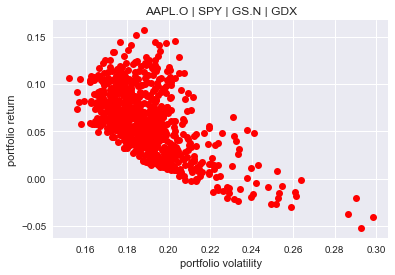

In [81]:
ps = simulate_port_stats(params['symbols'], 750)
fig = plt.figure()
plt.plot(ps[:, 0], ps[:, 1], 'ro')
plt.xlabel('portfolio volatility')
plt.ylabel('portfolio return')
plt.title(' | '.join(params['symbols']));
sht.pictures.add(fig, name='mpt', update=True)

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>